**DEFINING THE MODEL**

In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as T
import numpy as np

# Generalized UNet architecture from scratch for learning purposes. See https://arxiv.org/abs/1505.04597

class CNNBlock(nn.Module):

     # In the UNet architecture, this is the smallest possible block.
     # Each of these applies a 2D convolution, normalizes the output and passes it through a ReLU activation function.
     # The result of passing an input of size [N, in, H_in, W_in] through this layer is an output [N, out, H_out, W_out]
     #    where H_out = (H_in + 2*padding - dilation*(kernel_size-1) - 1)/stride + 1 
     #          W_out = (W_in + 2*padding - dilation*(kernel_size-1) - 1)/stride + 1 
     # This output corresponds to the element_wise result of the ReLU activation function of the normalized convolution output.

     # The block is used several times at each "level", which is why we later define a CNNSet, which is composed of several 
     # usages of the CNNBlock sequentially 

     """
     Parameters:
     in_channels (int): Number of channels in the input to the block.
     out_channels (int): Number of channels produced by the convolution of the input within the block.
     kernel_size (int): Size of the convolving kernel. Default = 3.
     stride (int) : Stride of the convolution. Default = 1.
     padding (int) : Padding added to all four sides of the input. Default = 0.
     """

     def __init__(self, in_channels: int, out_channels:int, kernel_size:int=3, stride:int=1, padding:int=0):
          super(CNNBlock, self).__init__()

          self.sequential_block = nn.Sequential(
               nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
               nn.BatchNorm2d(out_channels),
               nn.ReLU(inplace=True)
          )

     def forward(self, x):
          x = self.sequential_block(x)
          return x
     


class Encoder(nn.Module):

     # The encoder part of the UNet consists of the downsampling of the initial input through the application of 
     # a sequential series of convolution sets followed by a max pooling layer. The complete operation's objective 
     # is to capture the context and spatial information of the input image at different scales.

     """
     Parameters:
     in_channels (int): Number of input channels of the first CNNSet.
     out_channels (int): Number of output channels of the first CNNSet.
     padding (int): Padding applied in each convolution.
     levels (int): Number times a CNNSet + MaxPool2D layer is applied.
     """

     def __init__(self, input_channels:int, output_channels:int, pool_kernelsize: int, parameters: list):
          super(Encoder, self).__init__()
          self.encoder_layers = nn.ModuleList()
          levels = len(parameters)
          for level in range(levels-1):
               for conv in range(len(parameters[level])):
                    conv_kernelsize = parameters[level][conv][0]
                    conv_stride = parameters[level][conv][1]
                    self.encoder_layers.append(CNNBlock(in_channels=input_channels, out_channels=output_channels, kernel_size=conv_kernelsize, stride=conv_stride))
                    input_channels = output_channels
               output_channels *= 2
               self.encoder_layers.append(nn.MaxPool2d(pool_kernelsize))
          # A final convolution set is applied after all the levels, commonly referred to as the bottleneck
          for conv in range(len(parameters[-1])):
               conv_kernelsize = parameters[-1][conv][0]
               conv_stride = parameters[-1][conv][1]
               self.encoder_layers.append(CNNBlock(in_channels=input_channels, out_channels=output_channels, kernel_size=conv_kernelsize, stride=conv_stride))
               input_channels = output_channels

     def forward(self,x):
          residual_connection = []
          for i, layer in enumerate(self.encoder_layers):
               x = layer(x)
               # After the set CNN is processed, the result is logged to be sent in a connection to the decoder
               if i<len(self.encoder_layers)-1 and isinstance(self.encoder_layers[i+1], nn.MaxPool2d):
                    residual_connection.append(x)
               # If the processed layer is a pooling operation, the result is not logged
          return x, residual_connection



class Decoder(nn.Module):

     """
     Parameters:
     in_channels (int): Number of input channels of the first up-convolution layer.
     out_channels (int): Number of output channels of the first up-convolution layer.
     padding (int): Padding applied in each convolution.
     levels (int): number times an up-convolution + CNNSet is applied.
     """

     # After the encoder has downsampled the information, the decoder now applies an upsampling to match to original features.
     # This is achieved combining up-convolutions followed by convolution sets sequentially, achieving a recovery of the 
     # fine-grained spatial information lost during the downsampling in the encoder.

     def __init__(self, input_channels:int, exit_channels:int, uppool_kernelsize:int, parameters: list):
          super(Decoder, self).__init__()
          self.exit_channels = exit_channels
          self.decoder_layers = nn.ModuleList()

          levels = len(parameters)
          for level in range(levels-1):
               output_channels = int(input_channels/2)
               self.decoder_layers.append(nn.ConvTranspose2d(in_channels=input_channels, out_channels=output_channels, kernel_size=uppool_kernelsize, stride=uppool_kernelsize))
               for conv in range(len(parameters[level])):
                    conv_kernelsize = parameters[level][conv][0]
                    conv_stride = parameters[level][conv][1]
                    self.decoder_layers.append(CNNBlock(in_channels=input_channels, out_channels=output_channels, kernel_size=conv_kernelsize, stride=conv_stride))
                    input_channels = output_channels
          # A final convolution set without the ReLU activation function since the output will be passed through a BCELoss 
          self.decoder_layers.append(nn.Conv2d(in_channels=input_channels, out_channels=exit_channels, kernel_size=1))

     def forward(self, x, residual_connection):
          for i, layer in enumerate(self.decoder_layers):
               # After the previous output is up-sampled, the connection from the equivalent level is concatenated
               if i>0 and isinstance(self.decoder_layers[i-1], nn.ConvTranspose2d):
                    # First we center-crop the route tensor to make the size match
                    residual_connection[-1] = T.center_crop(residual_connection[-1], x.shape[2])
                    # Then we concatenate the tensors in the dimensions of the channels
                    x = torch.cat([x, residual_connection.pop(-1)], dim=1)
                    x = layer(x)
               # If the processed layer is an up-convolution operation, the connection is not performed
               else:
                    x = layer(x)
          return x


class UNetV2(nn.Module):

     """
     Parameters:
     in_channels (int): Number of input channels.
     first_out_channels (int): Number of output channels of the first convolution set.
     exit_channels (int): Number of output channels.
     levels (int): Number of levels for the encoder-decoder architecture.
     padding (int): Padding applied in each convolution operation.
     """

     # After the encoder has downsampled the information, the decoder now applies an upsampling to match to original features.
     # This is achieved combining up-convolutions followed by convolution sets sequentially, achieving a recovery of the 
     # fine-grained spatial information lost during the downsampling in the encoder.

     def __init__(self, in_channels, first_out_channels, exit_channels, pool_kernelsize, down_parameters, up_parameters, augment=False):
          super(UNetV2, self).__init__()
          levels = len(down_parameters)
          self.encoder = Encoder(input_channels=in_channels, output_channels=first_out_channels, pool_kernelsize=pool_kernelsize, parameters=down_parameters)
          self.decoder = Decoder(input_channels=first_out_channels*(2**(levels-1)), exit_channels=exit_channels, uppool_kernelsize=pool_kernelsize, parameters=up_parameters)
          self.augment = augment
        
     def forward(self, x):
          encoder_out, residuals = self.encoder(x)
          decoder_out = self.decoder(encoder_out, residuals)
          if self.augment: 
              return T.center_crop(decoder_out, (512,512))
          else:
              return T.center_crop(decoder_out, (256,256))

**DEFINING THE DATASET**

In [2]:
import torch
from PIL import Image
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
import random
import albumentations as A

def create_grid(nc: int, offset=0.5) -> torch.Tensor:
    grid = np.zeros((nc, nc, 2), dtype=np.float32)
    for ix in range(nc):
        for iy in range(nc):
            grid[ix, iy, 1] = -1 + 2 * (ix + 0.5) / nc + offset / 128
            grid[ix, iy, 0] = -1 + 2 * (iy + 0.5) / nc + offset / 128
    grid = torch.from_numpy(grid).unsqueeze(0)
    return grid

def img2tensor(img, dtype: np.dtype = np.float32):
    img = np.transpose(img, (2, 0, 1))
    tensor = torch.from_numpy(img.astype(dtype, copy=False))
    return tensor

class ContrailsDataset(Dataset):

     def __init__(self, path, use='train', soft_labels=False, only_positives=True, repeat=1, augment=False):
          if use == 'train' or use=='metrics':
               train = True
          else:
               train = False
          self.path = os.path.join(path, "train" if train else "validation", "images")
          if only_positives:
               positives_path = '/kaggle/input/positives'
               positives_file = np.load(os.path.join(positives_path,"positive_train.npy" if train else "positive_validation.npy"))
               positives_fnames = [filename.split("\\")[3] for filename in positives_file]
               if use == 'train' or use == 'cross-validate':
                    self.filenames = [filename.split(".")[0] for filename in os.listdir(self.path) if filename.split(".")[0] in positives_fnames]
               elif use == 'metrics':
                    self.filenames = random.sample([filename.split(".")[0] for filename in os.listdir(self.path) if filename.split(".")[0] in positives_fnames], 500)
          else:
               if use == 'train' or use == 'cross-validate':
                    self.filenames = [filename.split(".")[0] for filename in os.listdir(self.path)]
               elif use == 'metrics':
                    self.filenames = random.sample([filename.split(".")[0] for filename in os.listdir(self.path)],500)
          self.train = train
          self.nc = 3
          self.repeat = repeat
          self.soft_labels = soft_labels
          self.augment = augment 
          if self.augment:
               self.grid = create_grid(512, offset=0.5)

     def __len__(self):
          return self.repeat * len(self.filenames)
     
     def __getitem__(self, index):
          index = index % len(self.filenames)
          try:
               image = np.array(Image.open(os.path.join(self.path, self.filenames[index] + '.png')))
               if self.soft_labels:
                    mask  = np.load(os.path.join(self.path.replace('images','soft_label'), self.filenames[index] + '.npy'))
               else:
                    mask  = np.load(os.path.join(self.path.replace('images','ground_truth'), self.filenames[index] + '.npy'))
               image_tensor, mask_tensor = img2tensor(image/255), img2tensor(mask)   # Sizes 3x256x256 and 1x256x256  
               if self.augment:
                    transform = A.Compose([A.RandomRotate90(p=0.05),A.HorizontalFlip(p=0.05)])
                    image_tensor = T.resize(image_tensor,512)
                    mask_sym = F.grid_sample(mask_tensor.unsqueeze(0), self.grid, mode='bilinear', padding_mode='border', 
                                             align_corners=False).squeeze(0)
                    image_np = image_tensor.permute(1, 2, 0).numpy()
                    mask_np = mask_sym.permute(1, 2, 0).numpy()
                    # Apply augmentation
                    aug = transform(image=image_np, mask=mask_np)
                    transformed_image = aug['image'].transpose(2, 0, 1)
                    transformed_mask = aug['mask'].transpose(2, 0, 1)
                    image_tensor = torch.from_numpy(transformed_image)
                    mask_tensor = torch.from_numpy(transformed_mask)
               return image_tensor, mask_tensor
          except Exception as e:
               print(f"\n Error loading file: {e} \n")
               return None, None

**VALIDATION FUNCTIONS**

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def validate(net, usage, device, pad, test_batch_size=50, threshold=0.5):    

     testset = ContrailsDataset(path='/kaggle/input/opencontrails-png/SingleFrame_PNG', use=usage, augment=False)
     testloader = torch.utils.data.DataLoader(testset,batch_size=test_batch_size, shuffle=True, num_workers=0)

     criterion = nn.BCEWithLogitsLoss()

     # Positive pixels labelled as positive
     TP = 0
     # Negative pixels labelled as negative
     TN = 0
     # Positive pixels labelled as negative
     FN = 0
     # Negative pixels labelled as positive
     FP = 0

     running_loss = 0

     with torch.no_grad():
          for i, data in enumerate(testloader):
               images, labels = data
               images, labels = images.to(device), labels.to(device)
               images = F.pad(images,(pad,pad,pad,pad), mode='reflect')
               outputs = torch.sigmoid(net(images)).view(-1,1,256,256)
               binary_outputs = (outputs > threshold).float()

               loss = criterion(outputs, labels)
               running_loss += loss.item()

               TP += torch.sum((binary_outputs == 1) & (labels == 1)).item()
               TN += torch.sum((binary_outputs == 0) & (labels == 0)).item()
               FN += torch.sum((binary_outputs == 0) & (labels == 1)).item()
               FP += torch.sum((binary_outputs == 1) & (labels == 0)).item()

               print(f'Processing batch {i+1}/{len(testloader)}', end='\r')

     # Pixel Accuracy
     PA = TP/(TP+TN+FP+FN) if (TP+TN+FP+FN)>0 else '-'
     # Jaccard Coefficient
     IoU = TP/(TP+FP+FN) if (TP+FP+FN)>0 else '-'
     # Precision
     precision = TP/(TP+FP) if (TP+FP)>0 else '-'
     # Recall
     recall = TP/(TP+FN) if (TP+FN)>0 else '-'
     # F1 Score
     F1 = 2*(precision*recall/(precision+recall)) if ((TP+FP)>0 and (TP+FN)>0 and TP>0) else '-'
     # Dice Coefficient
     dice = 2*TP/(2*TP+FP+FN) if (TP+FP+FN)>0 else '-'

     return running_loss/len(testset), PA, IoU, precision, recall, F1, dice
          

def generate_loss_plots(loss_evolution, val_evolution, train_evolution, PA_evolution, IoU_evolution, recall_evolution, precision_evolution, F1_evolution, dice_evolution):
     plt.plot(range(len(loss_evolution)), loss_evolution)
     plt.xlabel('Mini-batch')
     plt.ylabel('Batch loss')
     plt.title('Running loss for each training mini-batch')
     plt.grid(True)
     plt.show()

     plt.plot(range(len(PA_evolution)), PA_evolution)
     plt.xlabel('Epoch')
     plt.ylabel('Precision Accuracy [-]')
     plt.title('Precision accuracy')
     plt.grid(True)
     plt.show()
     
     plt.plot(range(len(IoU_evolution)), IoU_evolution)
     plt.xlabel('Epoch')
     plt.ylabel('Jaccard Index [-]')
     plt.title('Jaccard Index')
     plt.grid(True)
     plt.show()

     plt.plot(range(len(recall_evolution)), recall_evolution)
     plt.xlabel('Epoch')
     plt.ylabel('Recall [-]')
     plt.title('Recall')
     plt.grid(True)
     plt.show()

     plt.plot(range(len(precision_evolution)), precision_evolution)
     plt.xlabel('Epoch')
     plt.ylabel('Precision [-]')
     plt.title('Precision')
     plt.grid(True)
     plt.show()

     plt.plot(range(len(F1_evolution)), F1_evolution)
     plt.xlabel('Epoch')
     plt.ylabel('F1 Score [-]')
     plt.title('F1 Score')
     plt.grid(True)
     plt.show()

     plt.plot(range(len(dice_evolution)), dice_evolution)
     plt.xlabel('Epoch')
     plt.ylabel('Dice Coefficient [-]')
     plt.title('Dice Coefficient')
     plt.grid(True)
     plt.show()

     plt.plot(range(len(val_evolution)), val_evolution, label='Validation')  
     plt.plot(range(len(train_evolution)), train_evolution, label='Training')  
     plt.xlabel('Epoch')
     plt.ylabel('Loss per mini-batch')
     plt.legend()
     plt.title('Loss across epochs')
     plt.grid(True)
     plt.show()

**TRAINING SCRIPT**

In [4]:
def parameter_generator(levels, convs, kernel_size):
     parameters = [[None for _ in range(convs)] for _ in range(levels)]
     for level in range(levels):
          for conv in range(convs):
               if isinstance(kernel_size,list):
                    parameters[level][conv] = [(kernel_size[level], kernel_size[level]), 1]
               else:
                    parameters[level][conv] = [(kernel_size, kernel_size), 1]
     return parameters

levs = 5
cons = 2
kers = 3

downparameters = parameter_generator(levs,cons,kers)
upparameters = parameter_generator(levs,cons,kers)


In [5]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 45.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=47d8e865e59894b9e715eb97e4c1371ad7f663b9f8d046eb10e70430dfeee346
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=8d5d305b03a3f7a15ce7b2e8790621c731654df356f39ec11f3296e94418619d
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficien

**TRAINING**

Using device: CUDA


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


model.safetensors:   0%|          | 0.00/264M [00:00<?, ?B/s]

Model number of learnable parameters: 95919341


Using optimizer ADAM

Beginning training...


Learning rate for the epoch is 1.00e-08
Epoch 1/13, batch 99/3087 with loss 0.0002791398243668179. Remaining training time: 6hr 58min.  
Warm-up learning rate: 4.21e-08
Epoch 1/13, batch 199/3087 with loss 0.00027320617421840626. Remaining training time: 6hr 51min.  
Warm-up learning rate: 7.41e-08
Epoch 1/13, batch 299/3087 with loss 0.0002263032365590334. Remaining training time: 6hr 46min.  
Warm-up learning rate: 1.06e-07
Epoch 1/13, batch 399/3087 with loss 8.199467750576635e-05. Remaining training time: 6hr 42min.  
Warm-up learning rate: 1.38e-07
Epoch 1/13, batch 499/3087 with loss 0.00019385935350631675. Remaining training time: 6hr 40min.  
Warm-up learning rate: 1.70e-07
Epoch 1/13, batch 599/3087 with loss 0.00010777413262985647. Remaining training time: 6hr 38min.  
Warm-up learning rate: 2.02e-07
Epoch 1/13, batch 699/3087 with loss 8.829230015786986e-05. Remaining training time

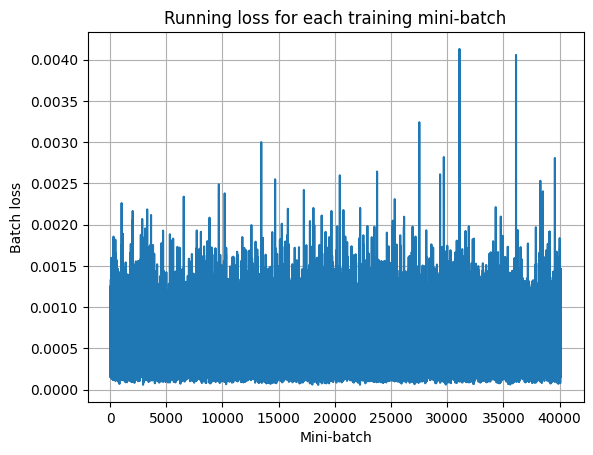

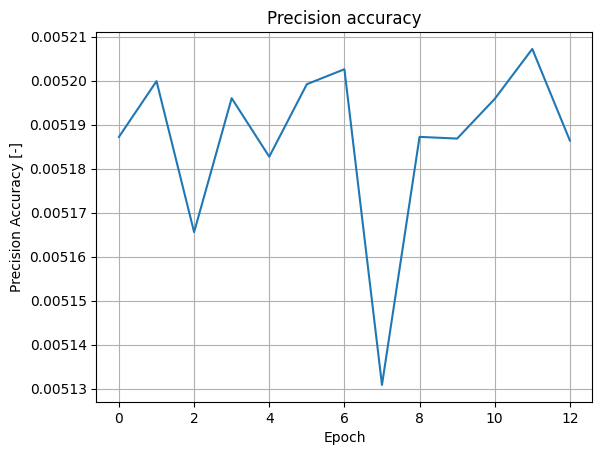

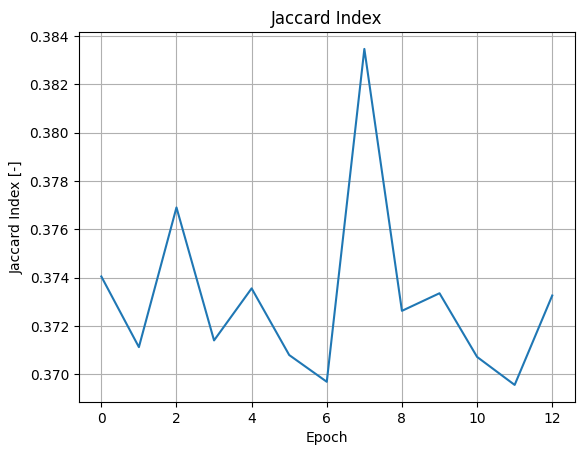

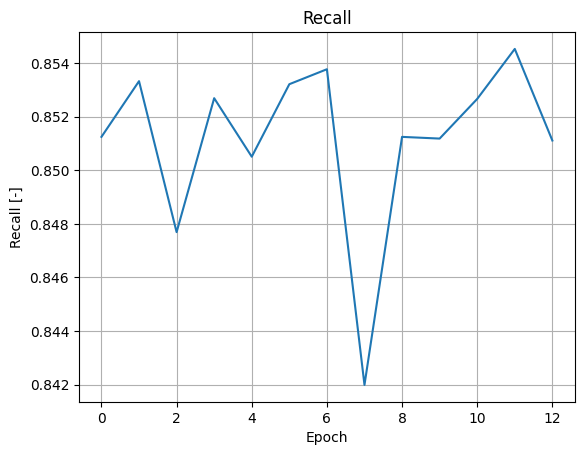

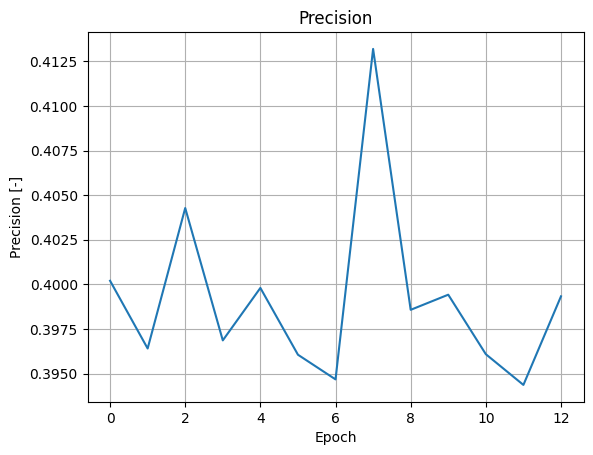

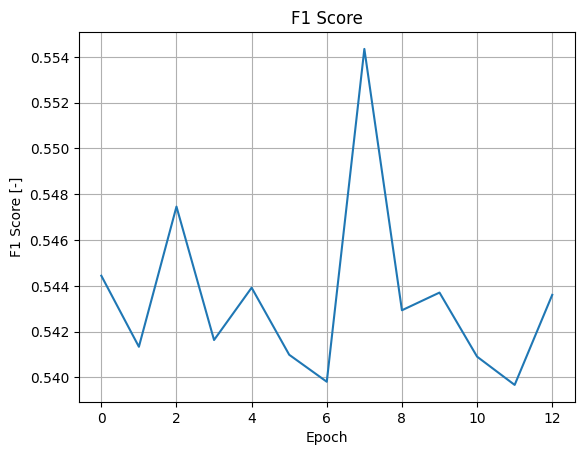

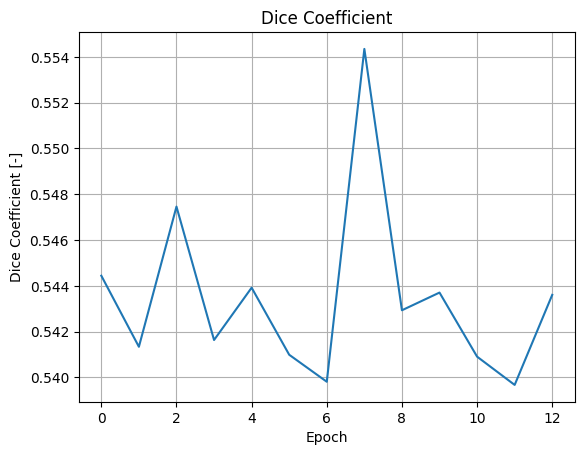

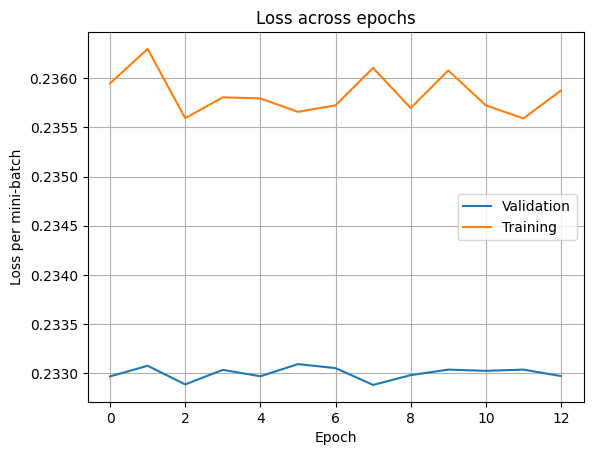

In [6]:
import torch
import numpy as np
import time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd.profiler as profiler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, LinearLR, ExponentialLR, ConstantLR
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from tqdm.auto import tqdm


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def main(name, optimization='adam', schedule='plateau', pretrained=False, select_device=False, only_positives=True, soft_label=True, train_batch_size=100, learning_rate=0.001, epoch=5, accum_iter=1, pad=94, augmentation=False):

    LRy = []
    LRx = []
    
    loss_evolution = []
    val_evolution = []
    train_evolution = []
    PA_evolution = []
    IoU_evolution = []
    precision_evolution = []
    recall_evolution = []
    F1_evolution = []
    dice_evolution = []
    dicetrain_evolution = []

    if select_device:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    else:
        device = 'cpu'
    print(f"Using device: {device.upper()}")

    # Load weights from pre-trained model of one epoch
    # net = UNetV2(in_channels=3, first_out_channels=64, exit_channels=1, pool_kernelsize=2, down_parameters=downparameters, up_parameters=upparameters, augment=augmentation).to(device)
    net = smp.Unet('tu-maxxvit_rmlp_small_rw_256.sw_in1k',classes=1, decoder_channels=[1024,512,256,128,64]).to(device)
    total_params = count_parameters(net)
    print(f"Model number of learnable parameters: {total_params}")
    
    if pretrained:
        path2trained = '/kaggle/input/trainedmaxvit/MaxViT_523_256_Positives_20epoch.pth'
        state_dict = torch.load(path2trained)
        net.load_state_dict(state_dict)
    
    print('\n')

    # Load the dataset      
    trainset = ContrailsDataset(path='/kaggle/input/opencontrails-png/SingleFrame_PNG', use='train', soft_labels=soft_label, only_positives=only_positives, augment=augmentation)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True, num_workers=0)

    # Optimize with SGD and BCE
    criterion = nn.BCEWithLogitsLoss()
    if optimization == 'adam':
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    elif optimization == 'adagrad':
        optimizer = optim.Adagrad(net.parameters(), lr=learning_rate)
    else:
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    
    print(f"Using optimizer {optimization.upper()}\n")
    
    warmup = LinearLR(optimizer, start_factor=0.01, end_factor=1, total_iters=len(trainloader)/accum_iter)
    
    if schedule == 'plateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.01, min_lr=0.0000000001)
    elif schedule == 'constant':
        scheduler = ConstantLR(optimizer, factor=1)
    elif schedule == 'step':
        scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    elif schedule == 'linear':
        scheduler = LinearLR(optimizer, start_factor=1, end_factor=0.0000001, total_iters=30)
    elif schedule == 'exponential':
        scheduler = ExponentialLR(optimizer, gamma=0.87)
        
    # Initialize statistics
    start_time = time.time()
    running_loss = 0

    print('Beginning training...', end='\n')
    
    print('\n')
    
    for e in range(epoch):
        print(f"Learning rate for the epoch is {optimizer.param_groups[0]['lr']:.2e}")
        for i, data in enumerate(trainloader):
            # Obtaining the inputs
            inputs, labels = data
            if inputs is None or labels is None:
                continue
            else:
                # Move inputs and labels to CUDA
                inputs, labels = inputs.to(device), labels.to(device)
                with torch.set_grad_enabled(True):
                    inputs = F.pad(inputs,(pad,pad,pad,pad), mode='reflect')
                    # Apply forward propagation
                    outputs = net(inputs)
                    # Calculate the loss function
                    loss = criterion(outputs, labels)
                    loss = loss / accum_iter
                    # Apply backpropagation
                    loss.backward()
                    running_loss += loss.item()

                    # Apply a step of SGD after several gradient accumulation steps
                    if ((i + 1) % accum_iter == 0) or (i + 1 == len(trainloader)):
                        optimizer.step()
                        optimizer.zero_grad()
                        if e == 0:
                            LRy.append(optimizer.param_groups[0]['lr'])
                            LRx.append(i/len(trainloader))
                            warmup.step()
                            print(f"\nWarm-up learning rate: {optimizer.param_groups[0]['lr']:.2e}")

            loss_evolution.append(loss.item())
            # Calculate statistics
            time_spent = time.time() - start_time
            remaining_batches = len(trainloader)*epoch - len(trainloader)*e - i - 1
            time_remaining = remaining_batches*(time_spent/(len(trainloader)*e+i+1))
            time_remaining_hours = int(np.floor(time_remaining / 3600))
            time_remaining_minutes = int(np.floor((time_remaining - time_remaining_hours*3600)/60))

            print(f'Epoch {e+1}/{epoch}, batch {i+1}/{len(trainloader)} with loss {loss_evolution[-1]/train_batch_size}. Remaining training time: {time_remaining_hours}hr {time_remaining_minutes}min.  ', end='\r')

        name_net = f'{name}_{20+e+1}epoch.pth'
        torch.save(net.state_dict(), name_net)
        
        running_loss = 0
        # net_metrics = UNetV2(in_channels=3, first_out_channels=64, exit_channels=1, pool_kernelsize=2, down_parameters=downparameters, up_parameters=upparameters, augment=augmentation).to(device)
        net_metrics = smp.Unet('tu-maxxvit_rmlp_small_rw_256.sw_in1k',classes=1, decoder_channels=[1024,512,256,128,64]).to(device)
        net_metrics.load_state_dict(net.state_dict())
        net_metrics.eval()
        loss_train, _, _, _, _, _, dice_train = validate(net_metrics, pad=pad, device=device, usage='metrics', test_batch_size=train_batch_size)
        print(f'\n Average running loss per example from training in epoch {e+1}: {loss_train}')
        train_evolution.append(loss_train)
        dicetrain_evolution.append(dice_train)
        print(f'Dice coefficient in training: {dice_train}')
        
        print(f'\n Beginning cross-validation in epoch {e+1}', end='\n')
        val_loss, PA, IoU, precision, recall, F1, dice = validate(net_metrics, pad=pad, device=device, usage='cross-validate', test_batch_size=train_batch_size)
        print(f'\n Average running loss per example from cross validation in epoch {e+1}: {val_loss}')
        print(f'Pixel accuracy: {PA}')
        print(f'Jaccard Index: {IoU}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'F1 Score: {F1}')
        print(f'Dice coefficient: {dice}', end='\n')
        
        PA_evolution.append(PA)
        IoU_evolution.append(IoU)
        precision_evolution.append(precision)
        recall_evolution.append(recall)
        F1_evolution.append(F1)
        dice_evolution.append(dice)
        val_evolution.append(val_loss)
        if e>0:
            LRy.append(optimizer.param_groups[0]['lr'])
            LRx.append(e)


        # Perform a step in the learning rate scheduler
        if schedule is not None:
            if schedule == 'plateau':
                scheduler.step(val_loss)
            else:
                scheduler.step()
            
        print('\n')
    
    print('\n Finished training.', end='\n')
    
    train_array = np.array(train_evolution)
    np.save('/kaggle/working/train.npy', train_array)
    loss_array = np.array(loss_evolution)
    np.save('/kaggle/working/loss.npy', loss_array)
    dicetrain_array = np.array(dicetrain_evolution)
    np.save('/kaggle/working/dicetrain.npy', dicetrain_array)
    PA_array = np.array(PA_evolution)
    np.save('/kaggle/working/PA.npy', PA_array)
    IoU_array = np.array(IoU_evolution)
    np.save('/kaggle/working/IoU.npy', IoU_array)
    precision_array = np.array(precision_evolution)
    np.save('/kaggle/working/precision.npy', precision_array)
    recall_array = np.array(recall_evolution)
    np.save('/kaggle/working/recall.npy', recall_array)
    F1_array = np.array(F1_evolution)
    np.save('/kaggle/working/F1.npy', F1_array)
    dice_array = np.array(dice_evolution)
    np.save('/kaggle/working/dice.npy', dice_array)
    val_array = np.array(val_evolution)
    np.save('/kaggle/working/val.npy', val_array)
    LRx_array = np.array(LRx)
    np.save('/kaggle/working/LRx.npy', LRx_array)
    LRy_array = np.array(LRy)
    np.save('/kaggle/working/LRy.npy', LRy_array)

    generate_loss_plots(loss_evolution, val_evolution, train_evolution, PA_evolution, IoU_evolution, recall_evolution, precision_evolution, F1_evolution, dice_evolution)
    
if __name__ == '__main__':
    main(schedule='plateau', optimization='adam', name='MaxViT_523_256_Positives', pad=0, pretrained=True, augmentation=False, soft_label=True, epoch=13, only_positives=True, learning_rate=0.000001, accum_iter=100, train_batch_size=3, select_device=True)

In [7]:
import os
# os.remove("/kaggle/working/UNETv2_SLPositives_4231_1epoch.pth")